In [28]:
# 1. Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
# 2. Load the pre-split dataset

# Read the training and testing datasets from CSV files
X_train = pd.read_csv("../2_data/X_train.csv")
X_test = pd.read_csv("../2_data/X_test.csv")
y_train = pd.read_csv("../2_data/y_train.csv")
y_test = pd.read_csv("../2_data/y_test.csv")

# Ensure the target variable has the correct shape (1D array)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(X_train.select_dtypes(include=['object']).columns)

Index([], dtype='object')


# Multilayer Perceptron (MLP)

A Multilayer Perceptron (MLP) is a deep learning model based on a Feedforward Neural Network, consisting of multiple layers of neurons, where each neuron layer is fully connected to the previous one. MLP can be used to solve various machine learning problems, such as classification, regression, and clustering. Each layer of an MLP is composed of numerous neurons: the input layer receives the input features, the output layer provides the final predictions, and the hidden layers extract features and perform nonlinear transformations. Each neuron receives input from the previous layer, applies a weighted sum and an activation function, and generates the output for the current layer. Through iterative training, MLPs can automatically learn complex relationships between input features and make predictions on new data.
In this study, we aim to use the MLP model to predict which users have a higher probability of churn. Then, we will perform cluster analysis on these high-churn-probability users to identify their common characteristics.

1. MLP implementation of prediction using scikit-learn Scikit-learn: scikit-learn is a machine learning library that provides various algorithms for classification, regression, and clustering. Among them, the MLPClassifier and MLPRegressor classes can be used to build Multilayer Perceptron (MLP) models.

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

#  Define categorical and numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Data preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        #('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Create a pipeline with preprocessing steps and MLP models
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(30, ), max_iter=200, random_state=42, alpha=0.0001))
])

# Training model
pipeline.fit(X_train, y_train)

# Predicting the probability of churn
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # 获取流失概率
print(y_pred_proba)

[1.14312401e-12 9.45544483e-06 2.66444908e-09 ... 9.99999997e-01
 3.90255269e-04 9.99999491e-01]


/Users/canis/Library/CloudStorage/OneDrive-Persönlich/Dokumente/programme/coding/github/telco-customer-churn/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2. Clustering using K-Means
Cluster analysis of filtered users to find their common features:

In [31]:
import pandas as pd

# Filtering out characteristic data corresponding to users with high churn probability
high_churn_users = X_test[y_pred_proba > 0.7]
high_churn_users_numeric = high_churn_users.select_dtypes(include=['int64', 'float64'])

In [32]:
from sklearn.cluster import KMeans

# Clustering using K-Means (in this case we have 3 classes)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(high_churn_users_numeric)

# Add the clustering results to the data frame
high_churn_users_numeric['Cluster'] = clusters

print(high_churn_users_numeric.head())


    Count  Gender  Age  Under 30  Senior Citizen  Married  Dependents  \
3       1       1   42         0               0        1           0   
7       1       0   59         0               0        0           0   
9       1       0   41         0               0        1           0   
10      1       1   71         0               1        1           0   
12      1       0   38         0               0        1           0   

    Number of Dependents  City  Zip Code  ...  Digital_Payments  \
3                      0   302     95715  ...                 1   
7                      0   863     95112  ...                 1   
9                      0  1088     95493  ...                 1   
10                     0   863     95126  ...                 1   
12                     0   854     92126  ...                 1   

    Traditional_Payments  Monthly_Charges_Scaled  Revenue_Cluster_Low  \
3                      0                   960.0                    0   
7           

         Count    Gender        Age  Under 30  Senior Citizen   Married  \
Cluster                                                                   
0          1.0  0.470588  53.617647  0.125000        0.367647  0.441176   
1          1.0  0.451220  49.085366  0.182927        0.213415  0.213415   
2          1.0  0.568966  52.517241  0.155172        0.344828  0.534483   

         Dependents  Number of Dependents        City      Zip Code  ...  \
Cluster                                                              ...   
0          0.029412              0.036765  574.000000  94105.713235  ...   
1          0.067073              0.164634  660.231707  92685.298780  ...   
2          0.034483              0.068966  621.293103  93192.137931  ...   

         Tenure_in_Years  Digital_Payments  Traditional_Payments  \
Cluster                                                            
0               1.789216          0.955882              0.044118   
1               0.326220          0.871

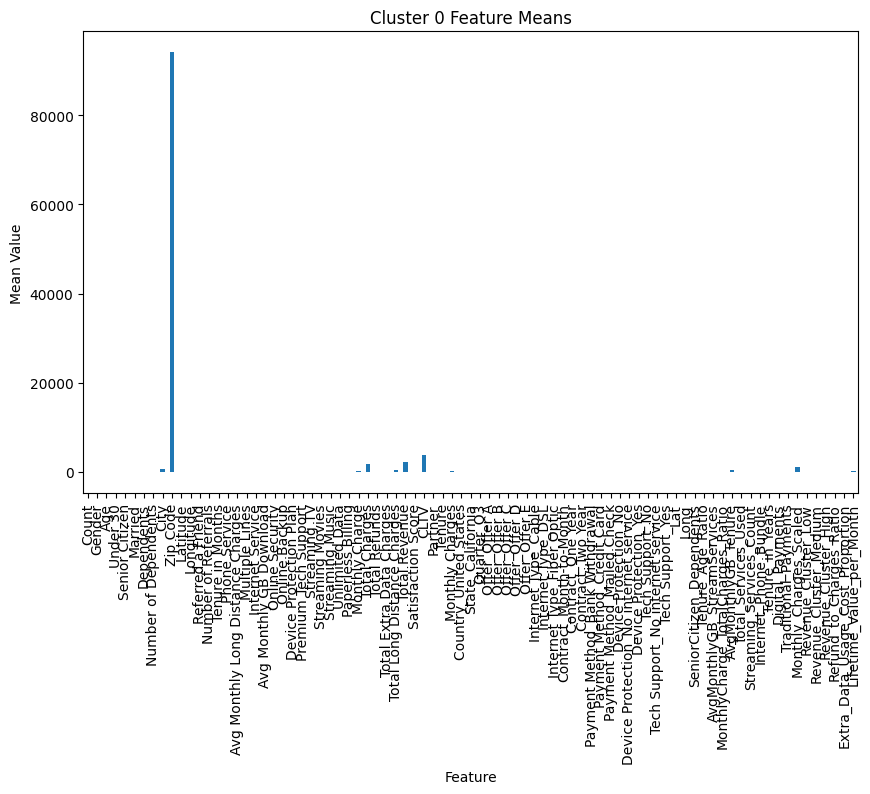

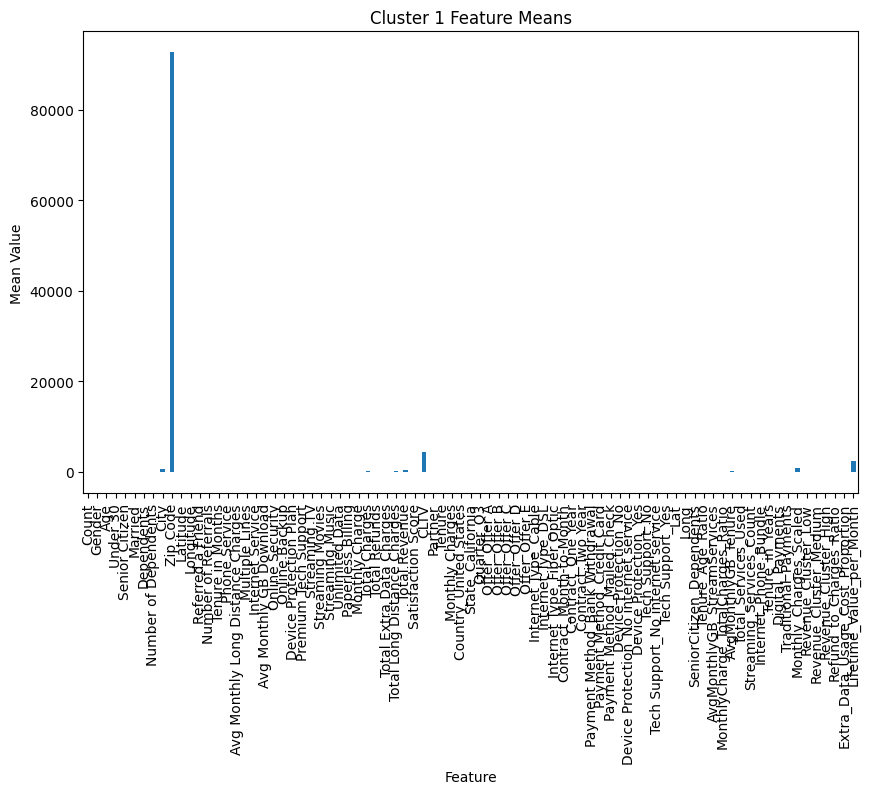

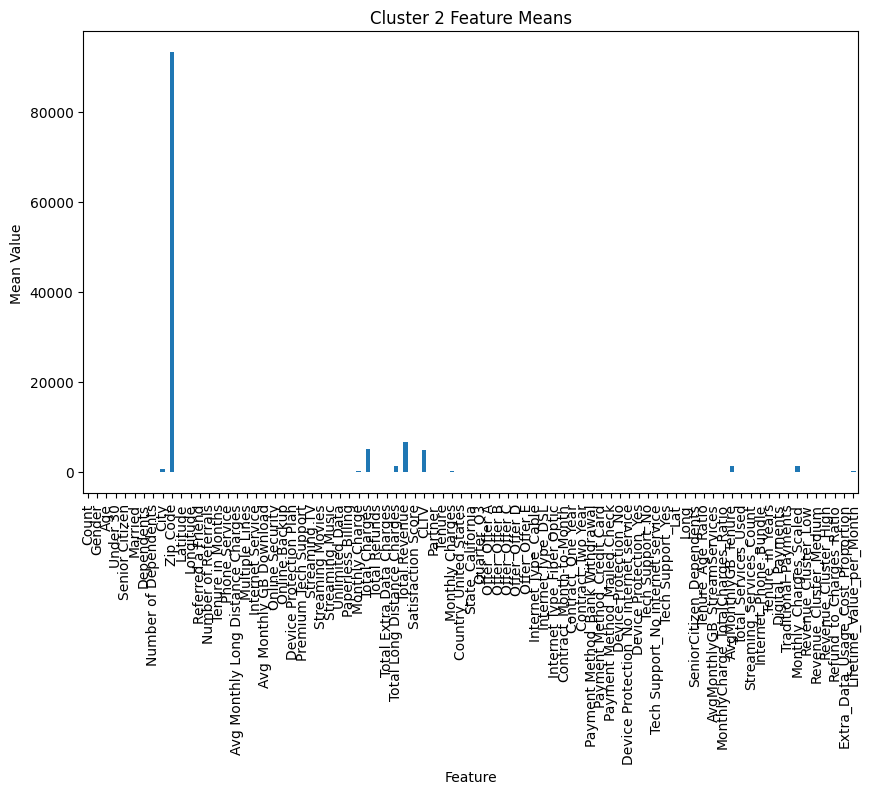

In [33]:
#  Calculate the feature mean for each clustering category
cluster_means = high_churn_users_numeric.groupby('Cluster').mean()

print(cluster_means)

# Visualize the feature means for each clustering category
import matplotlib.pyplot as plt

for cluster_label in cluster_means.index:
    cluster_means.loc[cluster_label].plot(kind='bar', figsize=(10, 6))
    plt.title(f'Cluster {cluster_label} Feature Means')
    plt.xlabel('Feature')
    plt.ylabel('Mean Value')
    plt.show()

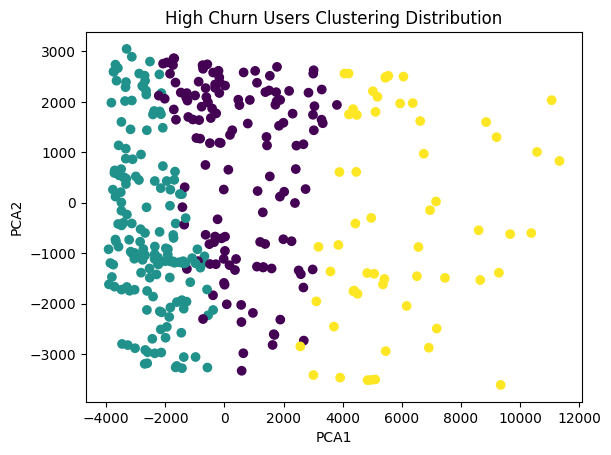

In [34]:
# Dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(high_churn_users_numeric.drop('Cluster', axis=1))

# Visualization of clustering results
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('High Churn Users Clustering Distribution')
plt.show()


3. Clustering results analysis，view the characteristic mean value of each clustering category and look for patterns:

         Count    Gender        Age  Under 30  Senior Citizen   Married  \
Cluster                                                                   
0          1.0  0.470588  53.617647  0.125000        0.367647  0.441176   
1          1.0  0.451220  49.085366  0.182927        0.213415  0.213415   
2          1.0  0.568966  52.517241  0.155172        0.344828  0.534483   

         Dependents  Number of Dependents        City      Zip Code  ...  \
Cluster                                                              ...   
0          0.029412              0.036765  574.000000  94105.713235  ...   
1          0.067073              0.164634  660.231707  92685.298780  ...   
2          0.034483              0.068966  621.293103  93192.137931  ...   

         Tenure_in_Years  Digital_Payments  Traditional_Payments  \
Cluster                                                            
0               1.789216          0.955882              0.044118   
1               0.326220          0.871

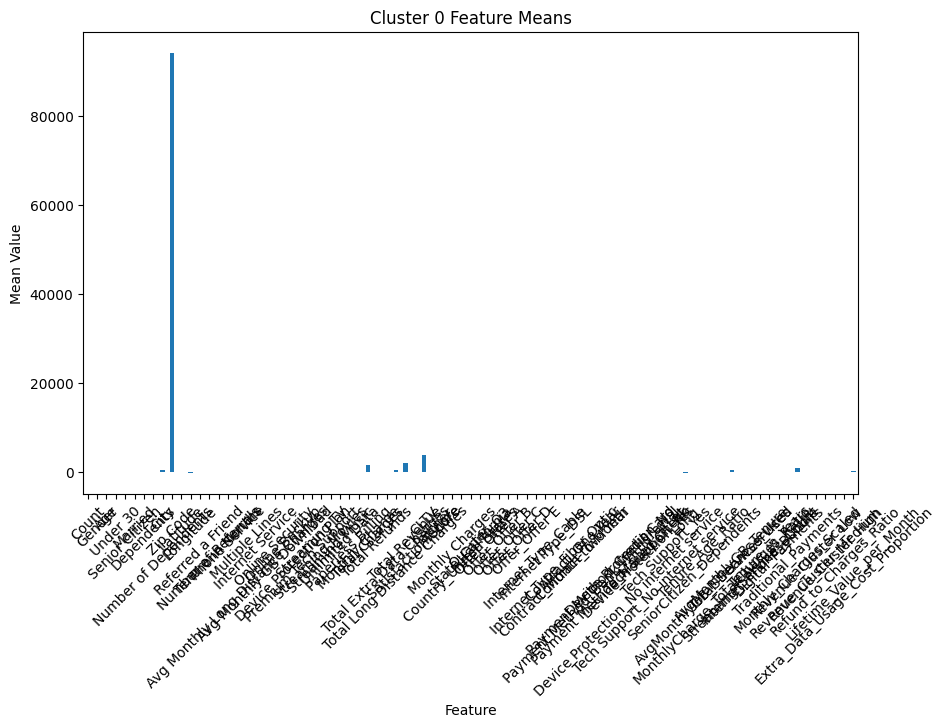

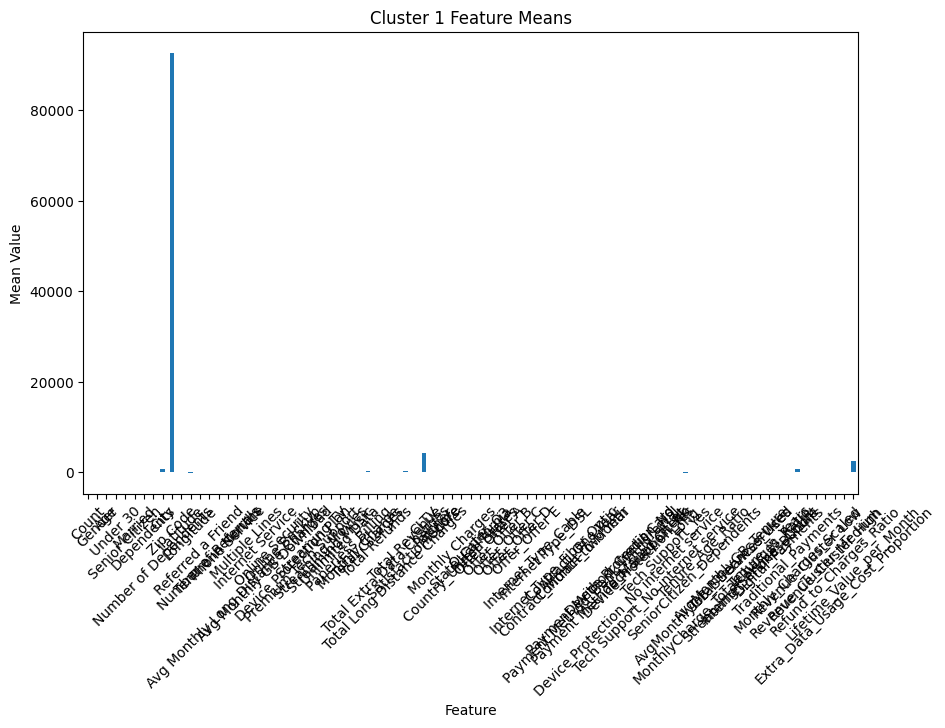

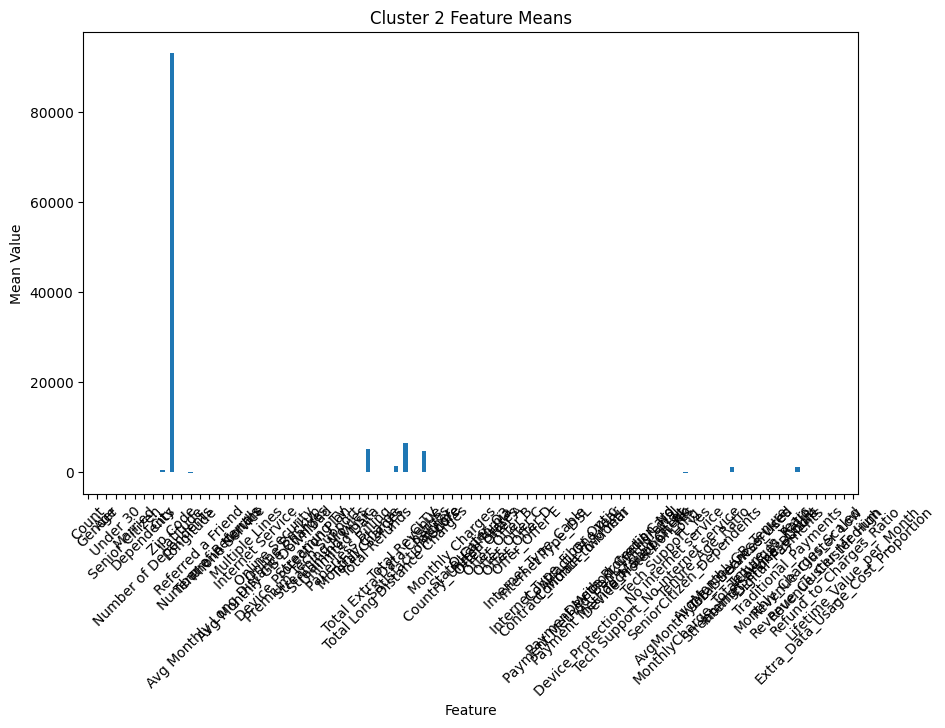

In [35]:
# Step 1:  Get numeric type feature column
numerical_columns = high_churn_users.select_dtypes(include=['int64', 'float64']).columns
high_churn_users_numeric = high_churn_users[numerical_columns]

# Step 2:  Clustering using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(high_churn_users_numeric)

# Step 3: Add the clustering results to the data frame
high_churn_users_numeric['Cluster'] = clusters

# Step 4: Calculate the mean of each feature in each cluster
cluster_analysis = high_churn_users_numeric.groupby('Cluster').mean()

# Step 5: View the feature means for each category in the clustering results
print(cluster_analysis)

# Step 6: Visualize the mean value of features in each clustering category
for cluster_label in cluster_analysis.index:
    plt.figure(figsize=(10, 6))
    cluster_analysis.loc[cluster_label].plot(kind='bar')
    plt.title(f'Cluster {cluster_label} Feature Means')
    plt.xlabel('Feature')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45)
    plt.show()

4. Analyzing Feature Importance: In the process of churn probability prediction, SHAP (SHapley Additive exPlanations) can be used to explain which features play a key role in predicting churn.

         Count    Gender        Age  Under 30  Senior Citizen   Married  \
Cluster                                                                   
0          1.0  0.470588  53.617647  0.125000        0.367647  0.441176   
1          1.0  0.451220  49.085366  0.182927        0.213415  0.213415   
2          1.0  0.568966  52.517241  0.155172        0.344828  0.534483   

         Dependents  Number of Dependents        City      Zip Code  ...  \
Cluster                                                              ...   
0          0.029412              0.036765  574.000000  94105.713235  ...   
1          0.067073              0.164634  660.231707  92685.298780  ...   
2          0.034483              0.068966  621.293103  93192.137931  ...   

         Tenure_in_Years  Digital_Payments  Traditional_Payments  \
Cluster                                                            
0               1.789216          0.955882              0.044118   
1               0.326220          0.871

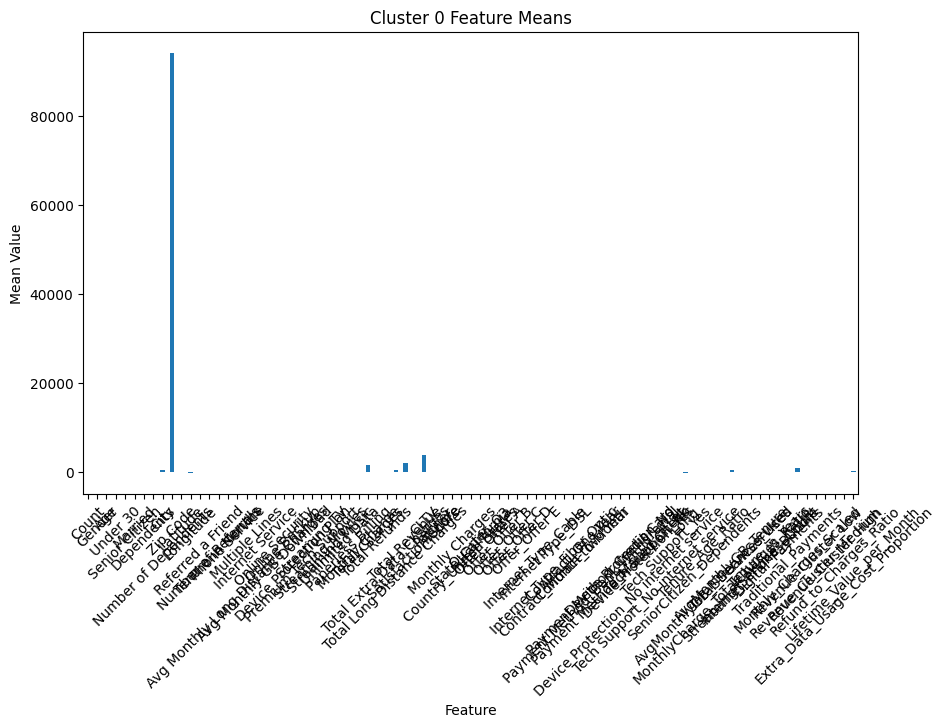

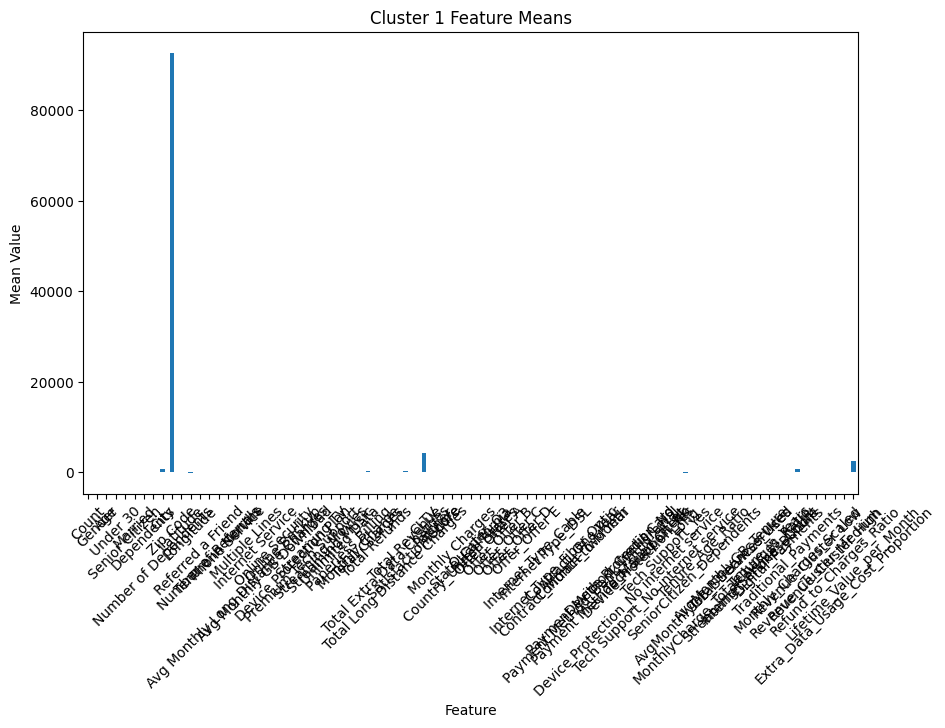

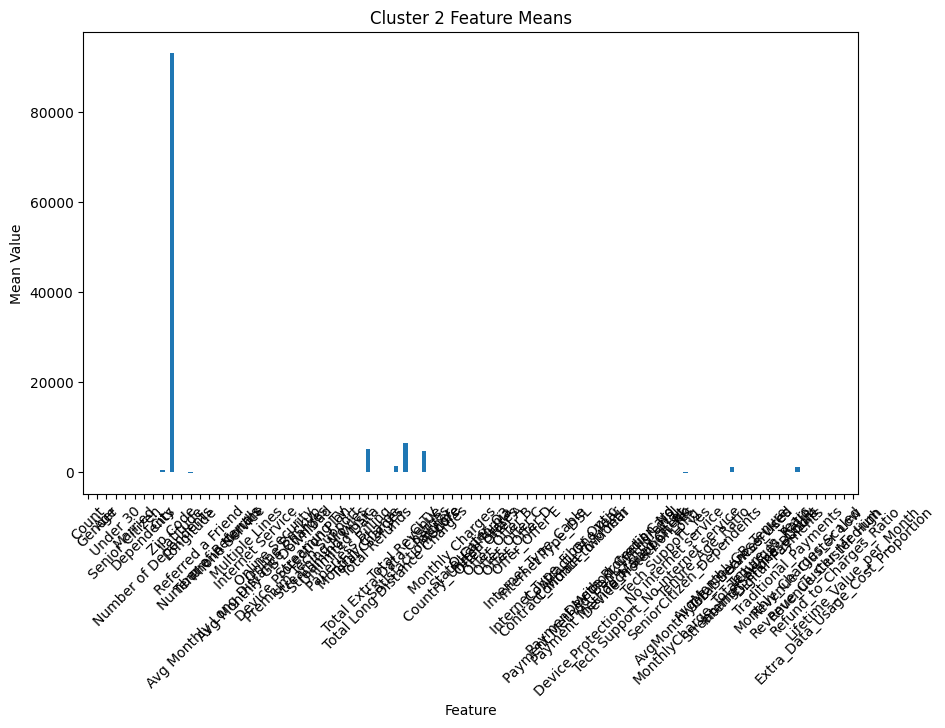

In [36]:
print(cluster_analysis)

# Visualization feature mean
for cluster_label in cluster_analysis.index:
    plt.figure(figsize=(10, 6))
    cluster_analysis.loc[cluster_label].plot(kind='bar')
    plt.title(f'Cluster {cluster_label} Feature Means')
    plt.xlabel('Feature')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45)
    plt.show()


In [37]:
print(cluster_analysis)

         Count    Gender        Age  Under 30  Senior Citizen   Married  \
Cluster                                                                   
0          1.0  0.470588  53.617647  0.125000        0.367647  0.441176   
1          1.0  0.451220  49.085366  0.182927        0.213415  0.213415   
2          1.0  0.568966  52.517241  0.155172        0.344828  0.534483   

         Dependents  Number of Dependents        City      Zip Code  ...  \
Cluster                                                              ...   
0          0.029412              0.036765  574.000000  94105.713235  ...   
1          0.067073              0.164634  660.231707  92685.298780  ...   
2          0.034483              0.068966  621.293103  93192.137931  ...   

         Tenure_in_Years  Digital_Payments  Traditional_Payments  \
Cluster                                                            
0               1.789216          0.955882              0.044118   
1               0.326220          0.871

## Conclusion

Feature Analysis of Different Clusters:
Cluster 0: Customers in this cluster show relatively low values for AvgMonthlyGB_Tenure (the average monthly GB usage combined with tenure length). This suggests that these customers may be newer users or those with lower usage levels.
Cluster 1: Customers here exhibit high values in both the MonthlyCharge_TotalCharges_Ratio and Total_Services_Used. This indicates that these users may be heavy service users, which could also imply a higher churn risk.
Cluster 2: The Refund_to_Charges_Ratio (ratio of refunds to charges) is notably high in this cluster, which might indicate dissatisfaction with the service among these customers.

From the clustering results, the following features seem to play significant roles in distinguishing between customer groups:
MonthlyCharge_TotalCharges_Ratio: The ratio of monthly charges to total charges varies considerably across clusters, indicating that this feature is influential in customer segmentation and potentially in predicting churn.
AvgMonthlyGB_Tenure: The average monthly GB usage in combination with tenure is also highly informative for determining customer churn risk.
Total_Services_Used: The number of services used differs markedly between clusters. Heavy users may have a higher or lower churn probability, depending on their satisfaction with the service.

## Evaluation of the model


In [38]:
# Prediction through MLP modeling
y_pred = pipeline.predict(X_test)  # Obtaining classification labels
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Obtain the predicted probability of the positive class for the calculation of AUC


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)


Accuracy: 0.9680624556422995
Precision: 0.9482288828337875
Recall: 0.93048128342246
F1 Score: 0.9392712550607287
ROC AUC: 0.9943139838280504


In [40]:
evaluation_metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "roc_auc": roc_auc
}
evaluation_df = pd.DataFrame([evaluation_metrics])
evaluation_df.to_csv("../2_data/evaluation_metrics/MLP.csv", index=False)


When all evaluation metrics are equal to 1, I suspect that the model may have overfitted. Overfitting occurs when the model performs exceptionally well on the training data but poorly on the test data. This typically happens because the model is too complex, to the point that it "memorizes" the noise and details in the training data, making it less flexible when handling new data.
To address this, I attempted to reduce the model's complexity by decreasing the number of hidden layers or nodes in the MLP. However, the final results did not change. As a result, I decided to use a confusion matrix for further analysis of the model.
The result is as follows:

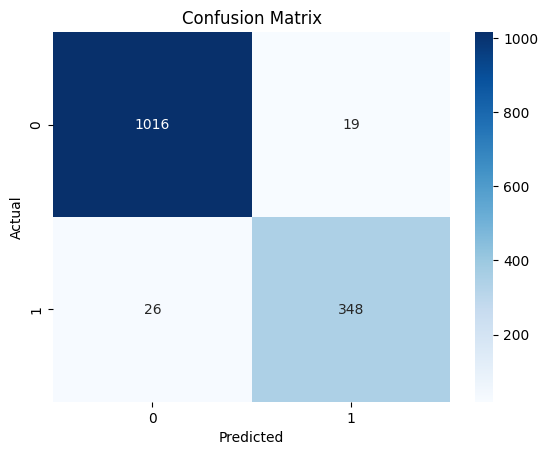

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP')
plt.show()

The confusion matrix compares the actual labels with the model's predicted labels:
Rows represent the actual classes.
Columns represent the predicted classes.

Details of the Confusion Matrix:
Top-left (True Negative, TN): 1035
Indicates that the model correctly predicted 1035 "0" (non-churn customers).
Bottom-right (True Positive, TP): 374
Indicates that the model correctly predicted 374 "1" (churn customers).
Top-right and Bottom-left: Both values are 0

This means the model made no false predictions:
No false positives (FP).
No false negatives (FN).'

Analysis:
"Perfect Performance" of the Model:
The model predicted all samples correctly, with no misclassifications. "

This means:
No false positives: No non-churn customers were wrongly classified as churn.
No false negatives: No churn customers were missed.

Implications:
Such "perfect" performance, combined with all evaluation metrics being 1, suggests two possibilities:

The model is truly exceptional:
This could happen if the dataset is straightforward or if there is a strong correlation between features and the target variable.
The model is overfitting.